### Loading & displaying a sample image from the dataset

In [3]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def show_image(path):
    img = Image.open(path)
    img_arr = np.array(img)
    plt.figure(figsize=(5,5))
    plt.imshow(np.transpose(img_arr, (0, 1, 2)))

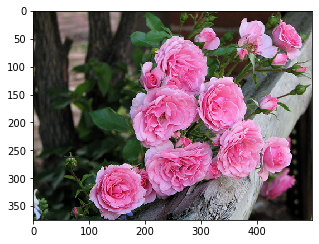

In [4]:
show_image("../data/flowers/rose/537207677_f96a0507bb.jpg")

### Loading the entire dataset and applying transformations

In [5]:
import torchvision.datasets as datasets
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

transformations = transforms.Compose([
    transforms.RandomResizedCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

total_dataset = datasets.ImageFolder("../data/flowers", transform = transformations)
dataset_loader = DataLoader(dataset = total_dataset, batch_size = 100)
items = iter(dataset_loader)
image, label = items.next()

In [6]:
total_dataset.class_to_idx

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

In [7]:
def show_transformed_image(image):
    np_image = image.numpy()
    plt.figure(figsize=(20,20))
    plt.imshow(np.transpose(np_image, (1, 2, 0)))

### Displaying the transformed images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


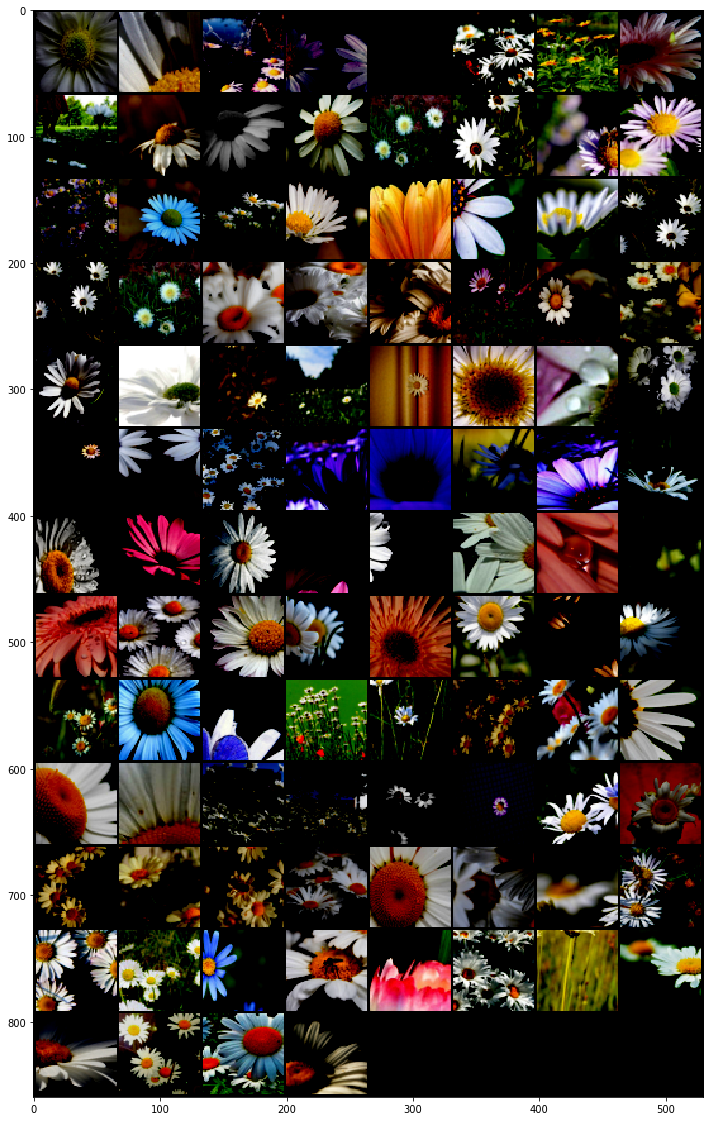

In [8]:
show_transformed_image(make_grid(image))

### Loading train & test dataset

In [9]:
from torch.utils.data import random_split

train_size = int(0.8 * len(total_dataset))
test_size = len(total_dataset) - train_size
train_dataset, test_dataset = random_split(total_dataset, [train_size, test_size])

train_dataset_loader = DataLoader(dataset = train_dataset, batch_size = 100)
test_dataset_loader = DataLoader(dataset = test_dataset, batch_size = 100)

### Building the CNN model

In [10]:
import torch.nn as nn

class FlowerClassifierCNNModel(nn.Module):
    
    def __init__(self, num_classes=5):
        super(FlowerClassifierCNNModel,self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3,stride=1, padding=1)
        self.relu1 = nn.ReLU()
        
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
        self.lf = nn.Linear(in_features=32 * 32 * 24, out_features=num_classes)
    
    def forward(self, input):
        output = self.conv1(input)
        output = self.relu1(output)
        
        output = self.maxpool1(output)
        
        output = self.conv2(output)
        output = self.relu2(output)
        
        output = output.view(-1, 32 * 32 * 24)

        output = self.lf(output)

        return output

In [11]:
from torch.optim import Adam

cnn_model = FlowerClassifierCNNModel()
optimizer = Adam(cnn_model.parameters())
loss_fn = nn.CrossEntropyLoss()

In [12]:
def train_and_build(n_epoches):
    for epoch in range(n_epoches):
        cnn_model.train()
        for i, (images, labels) in enumerate(train_dataset_loader):
            optimizer.zero_grad()
            outputs = cnn_model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

In [13]:
train_and_build(200)

### Evaluating model & accuracy

In [23]:
import torch

cnn_model.eval()
test_acc_count = 0
for k, (test_images, test_labels) in enumerate(test_dataset_loader):
    test_outputs = cnn_model(test_images)
    _, prediction = torch.max(test_outputs.data, 1)
    test_acc_count += torch.sum(prediction == test_labels.data).item()

test_accuracy = test_acc_count / len(test_dataset)

In [24]:
test_accuracy

0.7052023121387283

### Using the model for prediction with a sample image

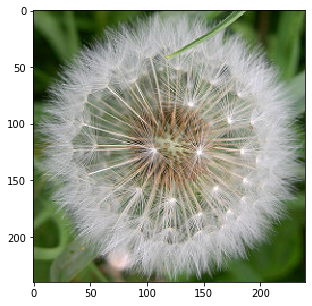

In [16]:
show_image("../data/flowers/dandelion/13920113_f03e867ea7_m.jpg")

In [17]:
test_image = Image.open("../data/flowers/dandelion/13920113_f03e867ea7_m.jpg")
test_image_tensor = transformations(test_image).float()
test_image_tensor = test_image_tensor.unsqueeze_(0)
output = cnn_model(test_image_tensor)
class_index = output.data.numpy().argmax()

In [18]:
class_index

1